In [202]:
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split

In [2]:
admissions = pd.read_csv(r'C:\Users\samsu\Desktop\Spring 2020\HAP 880\Final project\mimic-iii\ADMISSIONS.csv')

In [3]:
admissions.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [4]:
admissions.head()

ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare      NaN           CATHOLIC   
2           HOME HEALTH CARE  Medicare     ENGL           CATHOLIC   
3                       HOME   Private      NaN  PROTESTANT QUAKER   
4                       HOME   Private      NaN       UNOBTAINABLE   

  MARITAL_STATUS ETHNICITY            EDREGTIME            EDOUTTIME  \
0        MARRIED     WHITE  2196-04-09 10:06:00  2196-04-09 13:24:00   
1        MARRIED     WHITE                  NaN                  NaN   
2        MARRIED     WHITE                  NaN                  NaN   
3         SINGLE     WHITE                  NaN                  NaN   
4        MARRIED     WHITE  2160-11-02 01:01:00  2160-11-02 04:27:00   

                                           DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
0                            BENZODIAZEPINE OVERDOSE                     0   
1  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...                     0   
2                                         BRAIN MASS                     0   
3                     INTERIOR MYOCARDIAL INFARCTION                     0   
4                            ACUTE CORONARY SYNDROME                     0   

   HAS_CHARTEVENTS_DATA  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [5]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
ROW_ID                  58976 non-null int64
SUBJECT_ID              58976 non-null int64
HADM_ID                 58976 non-null int64
ADMITTIME               58976 non-null object
DISCHTIME               58976 non-null object
DEATHTIME               5854 non-null object
ADMISSION_TYPE          58976 non-null object
ADMISSION_LOCATION      58976 non-null object
DISCHARGE_LOCATION      58976 non-null object
INSURANCE               58976 non-null object
LANGUAGE                33644 non-null object
RELIGION                58518 non-null object
MARITAL_STATUS          48848 non-null object
ETHNICITY               58976 non-null object
EDREGTIME               30877 non-null object
EDOUTTIME               30877 non-null object
DIAGNOSIS               58951 non-null object
HOSPITAL_EXPIRE_FLAG    58976 non-null int64
HAS_CHARTEVENTS_DATA    58976 non-null int64
dtypes: int64(5), objec

In [6]:
admissions.groupby(['ADMISSION_TYPE']).size()

ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
NEWBORN       7863
URGENT        1336
dtype: int64

In [7]:
#Removing new borns
admissions = admissions.loc[admissions.ADMISSION_TYPE != 'NEWBORN']

In [8]:
#Rows with NEWBORN ADMISSION_TYPE are removed
admissions.groupby(['ADMISSION_TYPE']).size()

ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
URGENT        1336
dtype: int64

In [9]:
#Saving the dead patients for later usage
deadPatients = admissions.loc[admissions.DEATHTIME.notnull()]
print("Number of patients died:", len(deadPatients))

Number of patients died: 5792


In [10]:
#Removing pateints who are dead as they cant be readmitted
admissions = admissions.loc[admissions.DEATHTIME.isnull()]

In [11]:
#Checking whether the dead patients are removed
admissions.loc[admissions.DEATHTIME.notnull()]

Empty DataFrame
Columns: [ROW_ID, SUBJECT_ID, HADM_ID, ADMITTIME, DISCHTIME, DEATHTIME, ADMISSION_TYPE, ADMISSION_LOCATION, DISCHARGE_LOCATION, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY, EDREGTIME, EDOUTTIME, DIAGNOSIS, HOSPITAL_EXPIRE_FLAG, HAS_CHARTEVENTS_DATA]
Index: []

In [12]:
# Checking if there are any missing dates in the data
print('Missing admission dates:', admissions.ADMITTIME.isnull().sum())
print('Missing discharge dates:', admissions.DISCHTIME.isnull().sum())

Missing admission dates: 0
Missing discharge dates: 0


In [13]:
#convert the dates to proper format
admissions.ADMITTIME = pd.to_datetime(admissions.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions.DISCHTIME = pd.to_datetime(admissions.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions.DEATHTIME = pd.to_datetime(admissions.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [14]:
#Date and Time columns have been changed
admissions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45321 entries, 0 to 58975
Data columns (total 19 columns):
ROW_ID                  45321 non-null int64
SUBJECT_ID              45321 non-null int64
HADM_ID                 45321 non-null int64
ADMITTIME               45321 non-null datetime64[ns]
DISCHTIME               45321 non-null datetime64[ns]
DEATHTIME               0 non-null datetime64[ns]
ADMISSION_TYPE          45321 non-null object
ADMISSION_LOCATION      45321 non-null object
DISCHARGE_LOCATION      45321 non-null object
INSURANCE               45321 non-null object
LANGUAGE                30317 non-null object
RELIGION                44966 non-null object
MARITAL_STATUS          43346 non-null object
ETHNICITY               45321 non-null object
EDREGTIME               26792 non-null object
EDOUTTIME               26792 non-null object
DIAGNOSIS               45297 non-null object
HOSPITAL_EXPIRE_FLAG    45321 non-null int64
HAS_CHARTEVENTS_DATA    45321 non-null int64
dt

In [15]:
#Sorting the data by subject_ID and admission date to make sure we do not mess with different patients data
admissions = admissions.sort_values(['SUBJECT_ID','ADMITTIME'])
#When we reset the index, the old index is added as a column, and a new sequential index is used. 
#Use the 'drop' parameter to avoid the old index being added as a column
admissions = admissions.reset_index(drop = True)

In [16]:
#single patients data looks like this now
admissions.loc[admissions.SUBJECT_ID == 23]

ROW_ID  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
12      22          23   152223 2153-09-03 07:15:00 2153-09-08 19:10:00   
13      23          23   124321 2157-10-18 19:34:00 2157-10-25 14:00:00   

   DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION DISCHARGE_LOCATION  \
12       NaT       ELECTIVE  PHYS REFERRAL/NORMAL DELI   HOME HEALTH CARE   
13       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   HOME HEALTH CARE   

   INSURANCE LANGUAGE  RELIGION MARITAL_STATUS ETHNICITY EDREGTIME EDOUTTIME  \
12  Medicare      NaN  CATHOLIC        MARRIED     WHITE       NaN       NaN   
13  Medicare     ENGL  CATHOLIC        MARRIED     WHITE       NaN       NaN   

                                            DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
12  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...                     0   
13                                         BRAIN MASS                     0   

    HAS_CHARTEVENTS_DATA  
12                     1  
13                     1

In [17]:
#Add the next admission date and admission type for each subject using groupby 
#as the dates of all the patients are different. I am shifting the data by 1 
admissions['READMITTIME'] = admissions.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
admissions['READMISSION_TYPE'] = admissions.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [18]:
#Replacing rows of 'elective' admissions with NaT and NaN as we are only looking into emergency cases
temp = admissions.READMISSION_TYPE == 'ELECTIVE'
admissions.loc[temp,'READMITTIME'] = pd.NaT
admissions.loc[temp,'READMISSION_TYPE'] = np.NaN

In [19]:
admissions = admissions.sort_values(['SUBJECT_ID','ADMITTIME'])
#As I deleted the Elective type and time of admit, I am replacing them with any emergencies present later on
admissions[['READMITTIME','READMISSION_TYPE']] = admissions.groupby(['SUBJECT_ID'])[['READMITTIME','READMISSION_TYPE']].fillna(method = 'bfill')

In [20]:
#Calculating the number of days until the next admission
admissions['DAYS_NEXT_ADMIT'] = (admissions.READMITTIME - admissions.DISCHTIME).dt.total_seconds()/(24*60*60)

In [21]:
#Histogram plot unplanned re-admissions over a year
#plt.hist(admissions.loc[~admissions.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
#plt.title('Histogram unplanned re-admissions over 365 days')
#plt.xlabel('Days')
#plt.ylabel('Counts')
#plt.xlim([0,365])
#plt.xticks(np.arange(0, 365, 30))
#plt.show()

############################################################################################################################

In [22]:
notes = pd.read_csv(r'C:\Users\samsu\Desktop\Spring 2020\HAP 880\Final project\mimic-iii\NOTEEVENTS.csv')

C:\Users\samsu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
notes

ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE            CHARTTIME  \
0            174       22532  167853.0  2151-08-04                  NaN   
1            175       13702  107527.0  2118-06-14                  NaN   
2            176       13702  167118.0  2119-05-25                  NaN   
3            177       13702  196489.0  2124-08-18                  NaN   
4            178       26880  135453.0  2162-03-25                  NaN   
...          ...         ...       ...         ...                  ...   
2083175  2070657       31097  115637.0  2132-01-21  2132-01-21 03:27:00   
2083176  2070658       31097  115637.0  2132-01-21  2132-01-21 09:50:00   
2083177  2070659       31097  115637.0  2132-01-21  2132-01-21 16:42:00   
2083178  2070660       31097  115637.0  2132-01-21  2132-01-21 18:05:00   
2083179  2070661       31097  115637.0  2132-01-21  2132-01-21 18:05:00   

                   STORETIME           CATEGORY DESCRIPTION     CGID  ISERROR  \
0                        NaN  Discharge summary      Report      NaN      NaN   
1                        NaN  Discharge summary      Report      NaN      NaN   
2                        NaN  Discharge summary      Report      NaN      NaN   
3                        NaN  Discharge summary      Report      NaN      NaN   
4                        NaN  Discharge summary      Report      NaN      NaN   
...                      ...                ...         ...      ...      ...   
2083175  2132-01-21 03:38:00      Nursing/other      Report  17581.0      NaN   
2083176  2132-01-21 09:53:00      Nursing/other      Report  19211.0      NaN   
2083177  2132-01-21 16:44:00      Nursing/other      Report  20104.0      NaN   
2083178  2132-01-21 18:16:00      Nursing/other      Report  16023.0      NaN   
2083179  2132-01-21 18:31:00      Nursing/other      Report  16023.0      NaN   

                                                      TEXT  
0        Admission Date:  [**2151-7-16**]       Dischar...  
1        Admission Date:  [**2118-6-2**]       Discharg...  
2        Admission Date:  [**2119-5-4**]              D...  
3        Admission Date:  [**2124-7-21**]              ...  
4        Admission Date:  [**2162-3-3**]              D...  
...                                                    ...  
2083175  NPN\n\n\n#1  Infant remains in RA with O2 sats...  
2083176  Neonatology\nDOL #5, CGA 36 weeks.\n\nCVR: Con...  
2083177  Family Meeting Note\nFamily meeting held with ...  
2083178  NPN 1800\n\n\n#1 Resp: [**Known lastname 2243*...  
2083179  NPN 1800\nNursing Addendum:\n[**Known lastname...  

[2083180 rows x 11 columns]

In [24]:
notes['CATEGORY'].value_counts()

Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: CATEGORY, dtype: int64

In [25]:
notes.TEXT.iloc[0]

'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n'

In [26]:
#notes.HADM_ID.isnull().sum()

In [27]:
notes = notes[~notes['HADM_ID'].isin(deadPatients['HADM_ID'])]

In [28]:
#Concatenating different notes of a same person as one note based on CHARTDATE and CHARTTIME
#Convert CHARTDATE and CHARTTIME to proper date format
notes.CHARTDATE = pd.to_datetime(notes.CHARTDATE, format = '%Y-%m-%d', errors = 'coerce')
notes.CHARTTIME = pd.to_datetime(notes.CHARTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

notes = notes.sort_values(['SUBJECT_ID','CHARTDATE','CHARTTIME'])
notes = notes.reset_index(drop = True)

#Create a new dataframe as we only need these 2 columns
concat_notes = notes[['SUBJECT_ID', 'TEXT']].copy()

#Concatenating by each subject
concat_notes = concat_notes.groupby('SUBJECT_ID')['TEXT'].agg(' '.join).reset_index()
concat_notes.rename(columns={"TEXT":"TEXT_CONCAT"}, inplace=True)

C:\Users\samsu\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [29]:
#Using left join as we already preprocessed the admissions data
adm_notes = pd.merge(admissions[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','READMITTIME','READMISSION_TYPE','DEATHTIME']],
                    concat_notes, on = ['SUBJECT_ID'], how = 'left')

In [30]:
adm_notes.head(2)

SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0           3   145834 2101-10-20 19:08:00 2101-10-31 13:58:00   
1           4   185777 2191-03-16 00:28:00 2191-03-23 18:41:00   

   DAYS_NEXT_ADMIT READMITTIME READMISSION_TYPE DEATHTIME  \
0              NaN         NaT              NaN       NaT   
1              NaN         NaT              NaN       NaT   

                                         TEXT_CONCAT  
0  [**2101-10-6**] 6:02 PM\n CHEST (PORTABLE AP) ...  
1  [**2191-3-15**] 4:20 PM\n CHEST (PORTABLE AP) ...

In [31]:
#Creating a new binary column for readmission after and before 30 days
adm_notes['READMISSION'] = (adm_notes.DAYS_NEXT_ADMIT < 30).astype('int')

In [32]:
adm_notes['READMISSION'].value_counts()

0    42772
1     2549
Name: READMISSION, dtype: int64

In [33]:
adm_notes.loc[adm_notes.SUBJECT_ID==23]

SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
12          23   152223 2153-09-03 07:15:00 2153-09-08 19:10:00   
13          23   124321 2157-10-18 19:34:00 2157-10-25 14:00:00   

    DAYS_NEXT_ADMIT         READMITTIME READMISSION_TYPE DEATHTIME  \
12      1501.016667 2157-10-18 19:34:00        EMERGENCY       NaT   
13              NaN                 NaT              NaN       NaT   

                                          TEXT_CONCAT  READMISSION  
12  [**2153-8-16**] 5:01 PM\n CHEST (PRE-OP PA & L...            0  
13  [**2153-8-16**] 5:01 PM\n CHEST (PRE-OP PA & L...            0

In [34]:
#Copying the necessary columns in a new variable
notes_squashed_temp1 = adm_notes[['SUBJECT_ID', 'TEXT_CONCAT', 'READMISSION']]

#Summation of all the values in output label
notes_squashed_temp2 = notes_squashed_temp1.groupby('SUBJECT_ID')[['READMISSION']].sum().reset_index()

#Here if the value of output label is greater than 1, setting it to 1 otherwise 0
notes_squashed_temp2['READMISSION'] = (notes_squashed_temp2['READMISSION'] >= 1).astype(int)

#Dropping the old Readmission column so that we can merge both the temp datasets
notes_squashed_temp1.drop(columns=['READMISSION'], inplace=True)

#Removing extra obseravations of the same patients by keeping the first only 
notes_squashed_temp1.drop_duplicates(subset='SUBJECT_ID', keep='first', inplace=True)

#Checking the number of observations in both the datasets before merging, They should be equal
print('Length of notes_squashed_temp1:', len(notes_squashed_temp1))
print('Length of notes_squashed_temp2:', len(notes_squashed_temp2))

adm_notes_merged = pd.merge(notes_squashed_temp2,notes_squashed_temp1,on = ['SUBJECT_ID'],
                        how = 'left')

Length of notes_squashed_temp1: 34560
Length of notes_squashed_temp2: 34560


C:\Users\samsu\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\samsu\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
adm_notes_merged

SUBJECT_ID  READMISSION  \
0               3            0   
1               4            0   
2               6            0   
3              11            0   
4              13            0   
...           ...          ...   
34555       99985            0   
34556       99991            0   
34557       99992            0   
34558       99995            0   
34559       99999            0   

                                             TEXT_CONCAT  
0      [**2101-10-6**] 6:02 PM\n CHEST (PORTABLE AP) ...  
1      [**2191-3-15**] 4:20 PM\n CHEST (PORTABLE AP) ...  
2      [**2175-5-25**] 10:52 AM\n CHEST (PRE-OP PA & ...  
3      [**2178-4-16**] 5:01 AM\n MR HEAD W & W/O CONT...  
4      CCU ADMISSION NPN 1900-0700: LEFT MAIN\nHPI: I...  
...                                                  ...  
34555  Sinus rhythm. Normal ECG. Since the previous t...  
34556  [**2184-12-27**] 11:35 AM\n CHEST (PA & LAT)  ...  
34557  [**2144-7-10**] 8:04 AM\n CHEST PORT. LINE PLA...  
34558  [**2147-1-10**] 8:15 AM\n CAROTID SERIES COMPL...  
34559  Sinus rhythm.  Normal tracing.  Compared to th...  

[34560 rows x 3 columns]

In [36]:
adm_notes_merged.shape

(34560, 3)

In [37]:
adm_notes_merged.TEXT_CONCAT.iloc[0]

'[**2101-10-6**] 6:02 PM\n CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 47491**]\n Reason: please check picc tip placement. #4f, sl, v-cath for abx. pl\n ______________________________________________________________________________\n [**Hospital 2**] MEDICAL CONDITION:\n  76 year old man with cellulitis lower extremity.\n REASON FOR THIS EXAMINATION:\n  please check picc tip placement. #4f, sl, v-cath for abx. please page with stat\n  wet read to beeper # [**Numeric Identifier 1161**]. thanks\n ______________________________________________________________________________\n                                 FINAL REPORT\n INDICATIONS:  76 y/o male with lower extremity cellulitis, check PICC line\n placement.   Being presented for evaluation on [**2101-10-7**].  This study is\n compared with the prior exam of [**2101-8-22**].\n\n AP PORTABLE CHEST:   A left sided PICC line is seen with its tip in the\n atriocaval junction.  There is no

In [38]:
df = adm_notes_merged.copy()

In [39]:
import nltk
from nltk import word_tokenize
import string
import re

def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT_CONCAT = df.TEXT_CONCAT.fillna(' ')
    df.TEXT_CONCAT =df.TEXT_CONCAT.str.replace('\n',' ')
    df.TEXT_CONCAT =df.TEXT_CONCAT.str.replace('\r',' ')
    return df

df = preprocess_text(df)

In [40]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

In [41]:
def clean_textmain(text):
    text = text.lower()
    text ="".join([char for char in text if char not in string.punctuation ])
    result = re.sub(r'[0-9]+','',text)
    tokens = re.split('\W+', result)
    words = [word for word in tokens if word.isalpha()]
    text1=[word for word in words if word not in string.digits]
    text = [wn.lemmatize(word) for word in text1 if word not in stopwords]
    return text

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000,analyzer = clean_textmain)
wordCount = vect.fit_transform(df['TEXT_CONCAT'].astype(str))

In [43]:
wordCount_new =pd.DataFrame(wordCount.toarray())
wordCount_new.columns = vect.get_feature_names()

In [45]:
finalDf = df.join(wordCount_new,lsuffix='_caller', rsuffix='_other')
#check the column count(should have 3000 more)
finalDf.shape

(34560, 3003)

In [46]:
#Removing TEXT_CONCAT as its not useful further
finalDf = finalDf.drop(['TEXT_CONCAT'], axis=1)
finalDf.head(3)

SUBJECT_ID  READMISSION  aaa  ab  abd  abdomen  abdominal  abg  abgs  \
0           3            0    1   0    7        7          4    5     0   
1           4            0    0   0    4       22          3    0     0   
2           6            0    0   0    3        4          1    0     0   

   ablation  ...  yeast  yellow  yes  yesterday  yet  yo  yr  zofran  zone  \
0         0  ...      7       9    0          0    0   1   0       0     2   
1         0  ...      0       1    0          0    0   3   0       0     3   
2         0  ...      0       1    0          3    0   0   0       0     0   

   zosyn  
0      5  
1      0  
2      0  

[3 rows x 3002 columns]

In [1]:
finalDf.to_csv(r'C:\Users\samsu\Desktop\Spring 2020\HAP 880\Final project\adm_notes_merged.csv', index = False)

NameError: name 'adm_notes_merged' is not defined

In [ ]:
finalDf = pd.read_csv(r'C:\Users\samsu\Desktop\Spring 2020\HAP 880\Final project\adm_notes_merged.csv')

In [ ]:
finalDf.head(3)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(finalDf.drop(['READMISSION'], axis=1), finalDf['READMISSION'],
                                                    test_size=0.2, random_state=30)

In [63]:
#The class is clearly imbalanced here
y_train.value_counts()

0    26081
1     1567
Name: READMISSION, dtype: int64

In [134]:
#To balance the class setting class_weight parameter as balanced
lr = LogisticRegression(random_state = 30,class_weight="balanced")
lr.fit(X_train, y_train)
lrPredProbs_tr = lr.predict_proba(X_train)
lrPredProbs_ts = lr.predict_proba(X_test)
lrPred_tr = lr.predict(X_train)
lrPred_ts = lr.predict(X_test)
lrFpr_tr, lrTpr_tr, lrThresh_tr = roc_curve(y_train, lrPredProbs_tr[:,1])
lrFpr_ts, lrTpr_ts, lrThresh_ts = roc_curve(y_test, lrPredProbs_ts[:,1])

C:\Users\samsu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [148]:
print('Train Accuracy:%.3f'%accuracy_score(y_train, lrPred_tr))
print('Test Accuracy:%.3f'%accuracy_score(y_test, lrPred_ts))
print('Train Recall:%.3f'%recall_score(y_train, lrPred_tr))
print('Test Recall:%.3f'%recall_score(y_test, lrPred_ts))
print('Train Precision:%.3f'%precision_score(y_train, lrPred_tr))
print('Test Precision:%.3f'%precision_score(y_test, lrPred_ts))
print('Train AUC:%.3f'%roc_auc_score(y_train, lrPredProbs_tr[:,1]))
print('Test AUC:%.3f'%roc_auc_score(y_test, lrPredProbs_ts[:,1]))

Train Accuracy:0.748
Test Accuracy:0.746
Train Recall:0.848
Test Recall:0.801
Train Precision:0.165
Test Precision:0.150
Train AUC:0.884
Test AUC:0.846


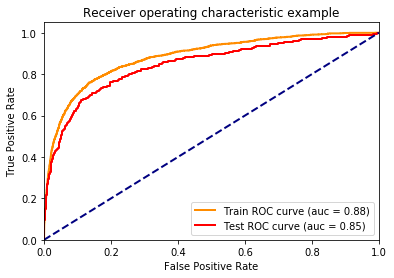

In [243]:
plt.figure()
plt.plot(lrFpr_tr, lrTpr_tr, color='darkorange',lw=2, label='Train ROC curve (auc = %0.2f)' % lrAuc_tr)
plt.plot(lrFpr_ts, lrTpr_ts, color='red',lw=2, label='Test ROC curve (auc = %0.2f)' % lrAuc_ts)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [198]:
confusion_matrix(y_test, lrPred_ts)

array([[4857, 1683],
       [  74,  298]], dtype=int64)

In [ ]:
#True positive (TP): Prediction is X should Readmit and X did, we want that
#True negative (TN): Prediction is X should not Readmit and X did not, we want that too
#False positive (FP): Prediction is X should Readmit and X did not, false alarm, bad
#False negative (FN): Prediction is X should not Readmit and X did, the worst

In [ ]:
#Recall/Sensitivity = TP/(TP+FN)--Appropriate for minimizing false negatives
#Specificity = TN/(TN+FP)
#Both should be balanced but we want FN to decrease with the cost of increase in FPs
#So after looking at the math we can have low specificity if FP inceases while achieving High Recall.
#I am tuning the model for better Recall.

In [248]:
C=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1)
class_weight = ['balanced','none']

# Create the random grid
random_grid = {'C':C,'class_weight': class_weight}
pprint(random_grid)

{'C': (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1),
 'class_weight': ['balanced', 'none']}


In [404]:
from pprint import pprint
#logistic = LogisticRegression(max_iter=4000,penalty='l2')
#lr_random = RandomizedSearchCV(estimator = logistic, param_distributions = random_grid,
#                               n_iter = 10,scoring='recall',cv= 3,verbose=2,random_state=30, n_jobs = -1)
#bestFit = lr_random.fit(X_train,y_train)

In [405]:
bestFit.best_params_

{'class_weight': 'balanced', 'C': 0.2}

In [238]:
#Running the model based on best paramters
lr1 = LogisticRegression(C=0.2,max_iter=4000,class_weight ='balanced',penalty='l2',random_state=30)
lr1.fit(X_train,y_train)
lr1PredProbs_tr = lr1.predict_proba(X_train)
lr1PredProbs_ts = lr1.predict_proba(X_test)
lr1Pred_tr = lr1.predict(X_train)
lr1Pred_ts = lr1.predict(X_test)
lr1Fpr_tr, lr1Tpr_tr, lr1Thresh_tr = roc_curve(y_train, lr1PredProbs_tr[:,1])
lr1Fpr_ts, lr1Tpr_ts, lr1Thresh_ts = roc_curve(y_test, lr1PredProbs_ts[:,1])

C:\Users\samsu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [239]:
print('Train Accuracy:%.3f'%accuracy_score(y_train, lr1Pred_tr))
print('Test Accuracy:%.3f'%accuracy_score(y_test, lr1Pred_ts))
print('Train Recall:%.3f'%recall_score(y_train, lr1Pred_tr))
print('Test Recall:%.3f'%recall_score(y_test, lr1Pred_ts))
print('Train Precision:%.3f'%precision_score(y_train, lr1Pred_tr))
print('Test Precision:%.3f'%precision_score(y_test, lr1Pred_ts))
print('Train AUC:%.3f'%roc_auc_score(y_train, lr1PredProbs_tr[:,1]))
print('Test AUC:%.3f'%roc_auc_score(y_test, lr1PredProbs_ts[:,1]))

Train Accuracy:0.877
Test Accuracy:0.850
Train Recall:0.946
Test Recall:0.610
Train Precision:0.309
Test Precision:0.203
Train AUC:0.967
Test AUC:0.765


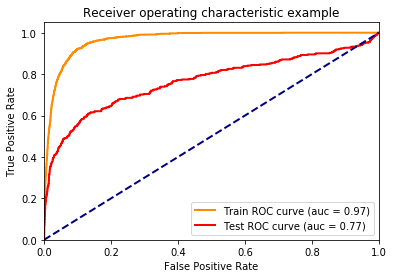

In [242]:
plt.figure()
plt.plot(lr1Fpr_tr, lr1Tpr_tr, color='darkorange',lw=2, label='Train ROC curve (auc = %0.2f)' %roc_auc_score(y_train, lr1PredProbs_tr[:,1]))
plt.plot(lr1Fpr_ts, lr1Tpr_ts, color='red',lw=2, label='Test ROC curve (auc = %0.2f)' %roc_auc_score(y_test, lr1PredProbs_ts[:,1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [253]:
confusion_matrix(y_test, lr1Pred_ts)

array([[5647,  893],
       [ 145,  227]], dtype=int64)

In [203]:
rf = RandomForestClassifier(random_state = 30)
rf.fit(X_train, y_train)
rfPredProbs_tr = rf.predict_proba(X_train)
rfPredProbs_ts = rf.predict_proba(X_test)
rfPred_tr = rf.predict(X_train)
rfPred_ts = rf.predict(X_test)
rfFpr_tr, rfTpr_tr, rfThresh_tr = roc_curve(y_train, rfPredProbs_tr[:,1])
rfFpr_ts, rfTpr_ts, rfThresh_ts = roc_curve(y_test, rfPredProbs_ts[:,1])

In [204]:
print('Train Accuracy:%.3f'%accuracy_score(y_train, rfPred_tr))
print('Test Accuracy:%.3f'%accuracy_score(y_test, rfPred_ts))
print('Train Recall:%.3f'%recall_score(y_train, rfPred_tr))
print('Test Recall:%.3f'%recall_score(y_test, rfPred_ts))
print('Train Precision:%.3f'%precision_score(y_train, rfPred_tr))
print('Test Precision:%.3f'%precision_score(y_test, rfPred_ts))
print('Train AUC:%.3f'%roc_auc_score(y_train, rfPredProbs_tr[:,1]))
print('Test AUC:%.3f'%roc_auc_score(y_test, rfPredProbs_ts[:,1]))

Train Accuracy:1.000
Test Accuracy:0.952
Train Recall:1.000
Test Recall:0.188
Train Precision:1.000
Test Precision:0.686
Train AUC:1.000
Test AUC:0.939


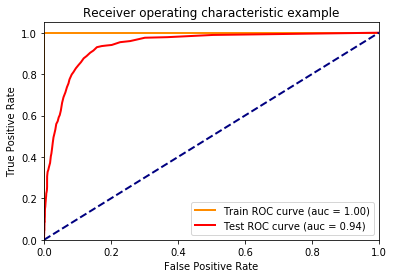

In [208]:
plt.figure()
plt.plot(rfFpr_tr, rfTpr_tr, color='darkorange',lw=2, label='Train ROC curve (auc = %0.2f)' %roc_auc_score(y_train, rfPredProbs_tr[:,1]))
plt.plot(rfFpr_ts, rfTpr_ts, color='red',lw=2, label='Test ROC curve (auc = %0.2f)' %roc_auc_score(y_test, rfPredProbs_ts[:,1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [209]:
confusion_matrix(y_test, rfPred_ts)

array([[6508,   32],
       [ 302,   70]], dtype=int64)

In [213]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Balancing the output labels
class_weight = ['balanced','balanced_subsample']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight}
pprint(random_grid)

{'bootstrap': [True, False],
 'class_weight': ['balanced', 'balanced_subsample'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [215]:
#randomForest = RandomForestClassifier()
#rf_random = RandomizedSearchCV(estimator = randomForest, param_distributions = random_grid, 
#                               n_iter = 100,scoring='recall',cv= 3,verbose=2, random_state=30, n_jobs = -1)
#bestFitRf = rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 63.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 216.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 449.6min finished


In [216]:
bestFitRf.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'class_weight': 'balanced',
 'bootstrap': True}

In [217]:
rf1 = RandomForestClassifier(n_estimators=200,min_samples_split=2,min_samples_leaf=4,max_features='auto',max_depth=10,
                             class_weight='balanced',bootstrap= True,n_jobs = -1,random_state = 30)
rf1.fit(X_train, y_train)
rf1PredProbs_tr = rf1.predict_proba(X_train)
rf1PredProbs_ts = rf1.predict_proba(X_test)
rf1Pred_tr = rf1.predict(X_train)
rf1Pred_ts = rf1.predict(X_test)
rf1Fpr_tr, rf1Tpr_tr, rf1Thresh_tr = roc_curve(y_train, rf1PredProbs_tr[:,1])
rf1Fpr_ts, rf1Tpr_ts, rf1Thresh_ts = roc_curve(y_test, rf1PredProbs_ts[:,1])

In [218]:
print('Train Accuracy:%.3f'%accuracy_score(y_train, rf1Pred_tr))
print('Test Accuracy:%.3f'%accuracy_score(y_test, rf1Pred_ts))
print('Train Recall:%.3f'%recall_score(y_train, rf1Pred_tr))
print('Test Recall:%.3f'%recall_score(y_test, rf1Pred_ts))
print('Train Precision:%.3f'%precision_score(y_train, rf1Pred_tr))
print('Test Precision:%.3f'%precision_score(y_test, rf1Pred_ts))
print('Train AUC:%.3f'%roc_auc_score(y_train, rf1PredProbs_tr[:,1]))
print('Test AUC:%.3f'%roc_auc_score(y_test, rf1PredProbs_ts[:,1]))

Train Accuracy:0.932
Test Accuracy:0.914
Train Recall:0.984
Test Recall:0.804
Train Precision:0.455
Test Precision:0.363
Train AUC:0.990
Test AUC:0.945


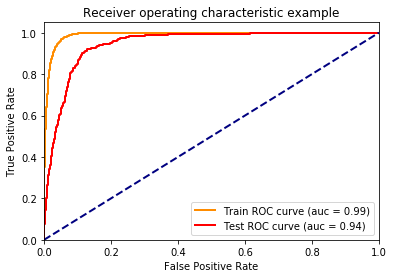

In [252]:
plt.figure()
plt.plot(rf1Fpr_tr, rf1Tpr_tr, color='darkorange',lw=2, label='Train ROC curve (auc = %0.2f)' %roc_auc_score(y_train, rf1PredProbs_tr[:,1]))
plt.plot(rf1Fpr_ts, rf1Tpr_ts, color='red',lw=2, label='Test ROC curve (auc = %0.2f)' %roc_auc_score(y_test, rf1PredProbs_ts[:,1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [254]:
confusion_matrix(y_test, rf1Pred_ts)

array([[6016,  524],
       [  73,  299]], dtype=int64)

In [282]:
#spanning over 2000 trees adding 100 at a time 
list_a = []
for n in range(100,2100,100):
    rf2 = RandomForestClassifier(n_estimators = n,n_jobs=-1)
    rf2.fit(X_train,y_train)
    probs = rf2.predict_proba(X_test)[:,1]
    a=roc_auc_score(y_test, probs)
    print(a)
    list_a.append(a)

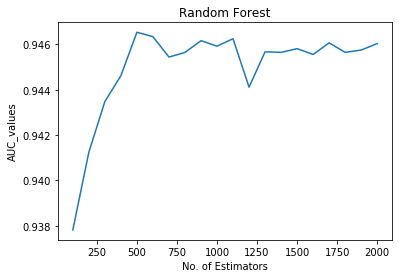

In [284]:
plt.plot(list(range(100,2100,100)),list_a)
plt.title('Random Forest')
plt.xlabel('No. of Estimators')
plt.ylabel('AUC_values')
plt.show()

In [295]:
cols = X_train.columns
rank = pd.DataFrame()
rank['columnNames'] = cols
rank['values'] = rf1.feature_importances_

In [297]:
#Adding 100 predictors at a time
list_b = []
x = len(rank.index)+100
for i in range(100,x,100):
    c = list(rank[1:i]['columnNames'])
    rf2 = RandomForestClassifier(n_estimators=150, n_jobs=-1)
    rf2.fit(X_train[c],y_train)
    probs = rf2.predict_proba(X_test[c])[:,1]
    a=roc_auc_score(y_test, probs)
    print(a)
    list_b.append(a)

0.9030825605866298
0.9078959915819933
0.9314723701949952
0.9303506543684852
0.9331798115813357
0.931527859984874
0.9337016211239355
0.9421105849856959
0.9414430633652298
0.9432080497188517
0.942666510473184
0.9407784189931274
0.9428913468810628
0.9437193778566966
0.9429164200453783
0.9447568314096872
0.9468804462201177
0.94489288415376
0.9420976373680576
0.9455782858176318
0.9439783302094638
0.9451436157969155
0.9430549390023346
0.9399894363881491
0.9432949837229949
0.9435631843740753
0.9454151047318403
0.9442613281378449
0.944781288020782
0.9427254940646477
0.9420692759198974


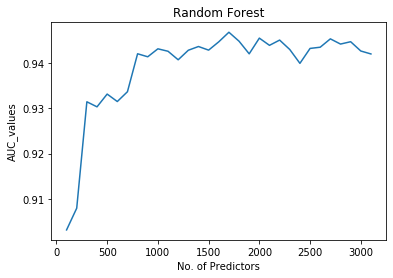

In [299]:
plt.plot(list(range(100,x,100)),list_b)
plt.title('Random Forest')
plt.xlabel('No. of Predictors')
plt.ylabel('AUC_values')
plt.show()

In [329]:
#adding 100 attributes at a time with 100 observations
size = []
auc_rf = []
y = len(X_train)+1000
for i in range(100,x,100):
    for j in range(100, 1100, 100):
        s = int(j/1000.0*len(X_train.index))
        size.append(s)
        print(s)
        c = list(rank[:i]['columnNames'])
        #print(c)
        rf2 = RandomForestClassifier(n_estimators=100,n_jobs=-1)
        rf2.fit(X_train[:s][c],y_train[:s])
        probs = rf2.predict_proba(X_test[c])[:,1]
        a=roc_auc_score(y_test, probs)
        print(a)
        auc_rf.append(a)

2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'allergy', 'allow', 'all

0.9019437867876755
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.8973942405708462
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9024357962579329
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9029943934760448
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9204991614876197
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9275066998783336
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9281308572555984
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9182727878070434
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9197023692085101
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9289582716780111
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.931080036828779
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.928493185031732
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'aller

0.9234421755285916
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9279421919700108
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9317206356252672
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9297036845220479
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9348457383841373
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9216942471474138
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.92600868106935
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'aller

0.932086662720726
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9291374831475453
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9328892094965637
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9233188648844168
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9239804264904146
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9357235046529218
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9354174887376279
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9335542649041466
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9200766170135806
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9291006954720331
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9310056394067936
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9324919437045807
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.93549661306764
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'aller

0.9394680378810298
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9364181546151065
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9385660205188913
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9412564532570452
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9416122044654894
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9194160829962842
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9310557857354247
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9327895333925225
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9346622110420573
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.937107050080563
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.93919305514452
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'aller

0.9319306747558449
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9378333497747524
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9383718062543158
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9412665236263195
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9217910460030909
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9304047055341818
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9355782036105358
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9324627601854591
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9369915491105192
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9377392226496992
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9392670415310249
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.938116553220874
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.942301099930946
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.938973562197889
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'aller

0.9171307257242445
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9295678372957153
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9330336884679884
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9323336950445562
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.938400784255697
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9381788250961823
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9387115270790175
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9415657574561835
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.937327159580415
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9385485515109664
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9198055391141364
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9264719180559666
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9339819473216928
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9353835783104798
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9369642152510604
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9361324849561015
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9357454950511328
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9377665565091579
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9380176991877939
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9399405231659597
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9232050080562955
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9293018973397784
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9361951678668903
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9354123507941206
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9405632419190424
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9404701423826904
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9390539196343429
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9407494409917464
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9425851254480286
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.942422355397718
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'aller

0.9237964881128539
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9311573114991287
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9342665893919964
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9362348327907666
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9427084360922036
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9379328203610535
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9376494113971918
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9402229045411199
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9440706076748544
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9424192726316135
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9241218226957351
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9296814886060965
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9361037124724606
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9354731840452468
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.941997139193055
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9388862171582651
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.942526141856565
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9384420933214955
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9406246917233896
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9423015109664266
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9239119890828976
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9310413994936044
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9348342293906811
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9339829749103943
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9405439232514551
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9401807734043602
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9397584344480616
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9405611867416396
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9428685344118904
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9408371970668508
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.927106351320246
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'aller

0.9306237874453323
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9364715892275821
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9390705665713065
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9373238712965704
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9402364687119793
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9409561918384794
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.943782471802966
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9416974943277103
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9438874913682549
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9190962973923908
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9309096626220776
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9334543832823649
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9363733517477228
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9378730146986288
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9425064121534971
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9424996300680675
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9405751619479794
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9409035792969649
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9413361941402782
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9208265512479037
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9277079017460788
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9332735276709087
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9378136200716846
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9377825868929005
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9380526372036434
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.937729974351386
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9410016112590839
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9416814639439677
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9393934349413042
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.924474491138075
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'aller

0.9301708263457302
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9337001824997534
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9352456759067442
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9397559682351782
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9410663493472756
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.939860371247246
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.94192294728881
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'aller

0.940798559731676
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9409553697675184
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9228558334155406
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9325774390845418
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.935307536746572
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9351053072901253
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9345610963138338
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9392421738844496
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9384562740455757
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9422273190621815
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9384073608233863
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9415353408306205
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9191530202887114
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9306959241721746
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9358394166584459
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9371167094143567
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9405334418467002
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.939119685311236
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9405864654236954
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9429865015948177
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9425540922692447
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9387429712932821
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9211393492486272
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9292244171516886
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9337550557364112
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9355753263621716
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9382010210121337
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9393661010818455
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9388802571437966
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9408388412087731
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9431490661273881
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9404232843379041
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9189544901515898
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9274771053237316
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9341759560685279
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9351106507513729
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9370219657360823
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9402050244977147
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9389608200979908
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9398768126664694
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.941496292459965
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9426371214363224
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9229590033211666
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9326493702936438
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9277804495084017
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9356277333859458
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9366610765841308
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9371105438821479
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.941730377166157
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9437407517016869
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9422145769622834
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.94405334418467
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'allerg

0.9190068971753642
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9319471161750683
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9363392358028345
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9333292229785275
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9373096905724903
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.939095639735622
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9410846404261617
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9421428512709218
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.941837657426589
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9424392078524217
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9129897487751143
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9284196096807076
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9344172338956298
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9350344036697247
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9411744516786689
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9374658840551117
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.940017592318569
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9437602758870146
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.943307725822893
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9420476965571668
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9222209891157805
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9344634753871954
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9331175397060274
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9365622225510506
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9382373976521654
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9408961806583145
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9402520880602414
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9419056837986255
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9410194913024892
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.942803385288218
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'aller

0.9234937604814049
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9289424468120088
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.935684250764526
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9415949409753049
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.936495429285456
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9357457005688731
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9375894002170266
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9408369915491105
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9399022968662656
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.941350169346618
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'aller

0.9206874157377265
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.927411134129098
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'aller

0.9324348097727795
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9344608036565717
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9369679145703858
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9423039771793101
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9407527292755911
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9389176613725296
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9433558169741212
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.939688147380882
2764
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'aller

0.9248090740192694
5529
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9260506066883694
8294
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9317870178553813
11059
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9345349955608168
13824
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9389924698299957
16588
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.937837871165039
19353
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'alle

0.9427008319358128
22118
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9390898852388938
24883
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9406195537798823
27648
['SUBJECT_ID', 'aaa', 'ab', 'abd', 'abdomen', 'abdominal', 'abg', 'abgs', 'ablation', 'able', 'abnormal', 'abnormality', 'abp', 'abrasion', 'abscess', 'absence', 'absent', 'abuse', 'abx', 'ac', 'acceptable', 'access', 'accessory', 'accident', 'according', 'ace', 'acetaminophen', 'acid', 'acidosis', 'acquired', 'across', 'action', 'active', 'activity', 'acute', 'acyclovir', 'add', 'added', 'addendum', 'addition', 'additional', 'additionally', 'address', 'adenopathy', 'adequate', 'adjacent', 'adjust', 'adjusted', 'adm', 'administered', 'administration', 'admission', 'admit', 'admitted', 'admitting', 'adrenal', 'advance', 'advanced', 'aeration', 'aerosol', 'af', 'afebrile', 'affect', 'afib', 'afternoon', 'age', 'agent', 'aggressive', 'agitated', 'agitation', 'ago', 'agree', 'aid', 'air', 'airspace', 'airway', 'akinetic', 'alarm', 'albumin', 'albuterol', 'alcohol', 'alcoholic', 'alert', 'alignment', 'aline', 'alk', 'alkalosis', 'alkphos', 'allergiesreactions', 'all

0.9396439610667193


In [331]:
b=[]
for i in range(100,x,100):
    for j in range(100, 1100, 100):
        c = list(rank[:i]['columnNames'])
        a = len(c)
        b.append(a)

In [333]:
print(len(b))
print(len(auc_rf))
print(len(size))

310
310
310


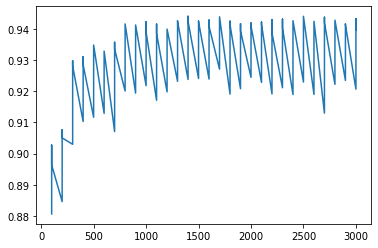

In [403]:
#AUC values for 1/10th observations and different number of predictors(incremented by 100)
#number of predictors(incremented by 100) for 1/10th observations added at a time
plt.plot(b,auc_rf)

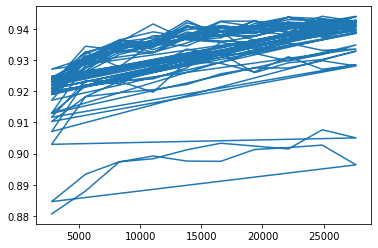

In [378]:
#AUC values for different number of predictors(incremented by 100) and 1/10th observations added at a time
plt.plot(size,auc_rf)

Text(0.5, 0, 'AUC_values')

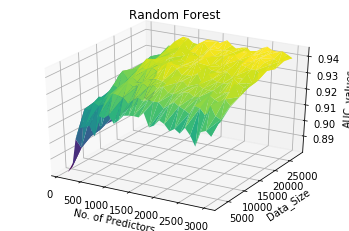

In [376]:
#X-axis represents the size of the attributes 100 at a time for 2700 rows .
#Y-axis represents the size of the data.
#Z-axis represents the AUC values.
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.plot_trisurf(b,size,auc_rf, cmap='viridis', edgecolor='none')
plt.title('Random Forest')
ax.set_xlabel('No. of Predictors')
ax.set_ylabel('Data_Size')
ax.set_zlabel('AUC_values')

In [359]:
#Caliberation Curves


In [ ]:
#Put the results in a table df_test_perf_metrics = pd.DataFrame([
#    [train_prevalence, test_prevalence],
#    [train_recall, test_recall], 
#   [train_precision, test_precision],
#   [auc_train, auc_test]], columns=['Training', 'Test'])